In [190]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.constants import c, R_jup, M_jup, G, GM_jup, sigma_sb, M_sun, L_sun
import astropy.units as u
from scipy.interpolate import interp1d, interp2d
import cmocean
from scipy.stats import loguniform
import sys
sys.path.append("../python/")
from utils import temperature, heat, temperature_withDM
import bokeh.palettes
from _corner import corner
import pickle
from scipy.stats import gaussian_kde

from matplotlib import rc
rc('font', family='times new roman', size=22.)

### Theoretical BD evolution model, taken from Saumon & Marley '08 (fig 2)

In [2]:
def heat(temp, R, epsilon=1):
    return (4*np.pi*R**2*sigma_sb*temp**4*epsilon)

def temp(heat, R, epsilon=1):
    return np.power(heat/(4*np.pi*R**2*sigma_sb*epsilon), 0.25)

In [103]:
age  = {}
logL = {}
L    = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
Teff = {}
for mass in M:
    data = np.genfromtxt("../data/saumon_marley_fig2_" + str(mass) + ".dat", unpack=True)
    age[mass]  = data[0]
    logL[mass] = data[1]
    L[mass]    = np.power(10, data[1])*L_sun
    Teff[mass] = temp(L[mass], R_jup)

(6.0, 10.0)

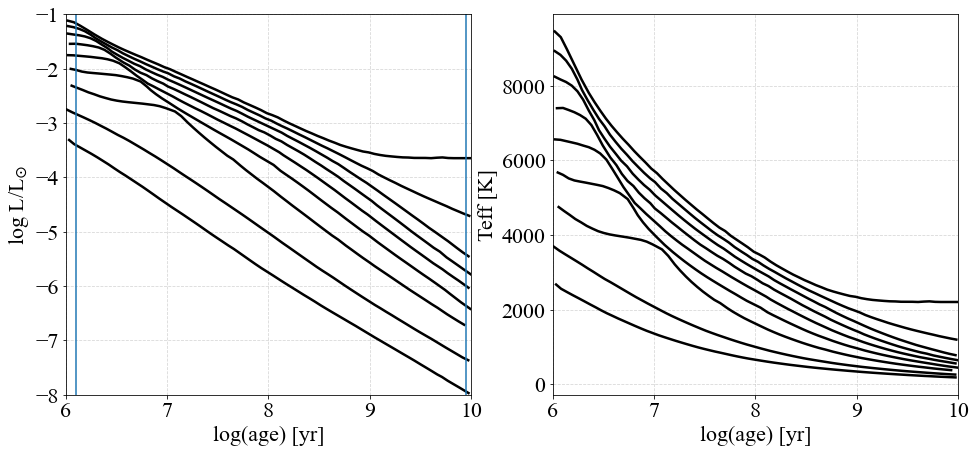

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

for mass in M:
    ax[0].plot(age[mass], logL[mass], color="k", lw=2.5)
    ax[1].plot(age[mass], Teff[mass], color="k", lw=2.5)

ax[0].set_ylabel("log L/L$_{\odot}$")
ax[0].set_xlabel("log(age) [yr]")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_ylim([-8, -1])
ax[0].set_xlim([6, 10])
ax[0].axvline(6.1)
ax[0].axvline(9.95)

ax[1].set_ylabel("Teff [K]")
ax[1].set_xlabel("log(age) [yr]")
ax[1].grid(which="both", ls="--", alpha=0.5)
ax[1].set_xlim([6, 10])

In [116]:
log_age  = np.linspace(6.1, 9.9, 10)
_log_age = []
_mass    = []
_teff    = []

for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))

Teff_interp_2d = interp2d(_log_age, _mass, _teff)
_teff = np.asarray(_teff)

Text(0.5, 0, 'log(age) [yr]')

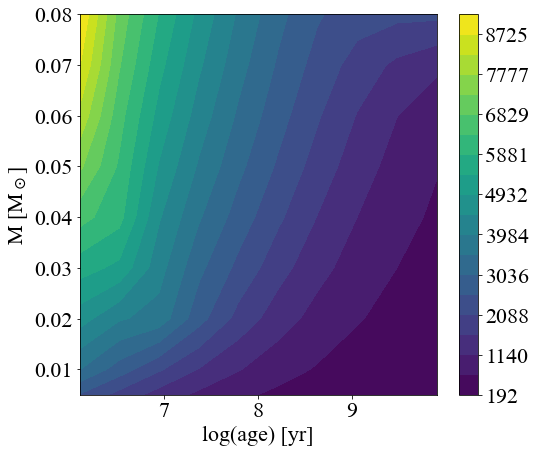

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

Z = _teff.reshape(len(M), len(log_age))

X, Y = np.meshgrid(log_age, M)

levels = np.linspace(np.min(_teff), np.max(_teff), 20)

cs = ax.contourf(X, Y, Z, levels=levels)
cbar = fig.colorbar(cs)

ax.set_ylabel("M [M$_\odot$]")
ax.set_xlabel("log(age) [yr]")

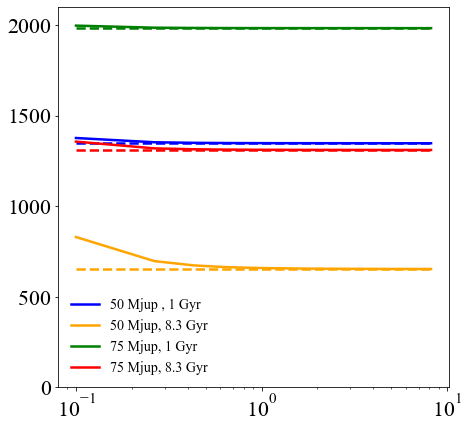

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

r = np.linspace(0.1, 8.178, 50)
m = 50.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup , 1 Gyr", lw=2.5, color="blue")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="blue")

m = 50.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup, 8.3 Gyr", lw=2.5, color="orange")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="orange")

m = 75.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup, 1 Gyr", lw=2.5, color="green")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="green")

m = 75.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup, 8.3 Gyr", lw=2.5, color="red")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="red")

ax.legend(frameon=False, fontsize=14)
ax.set_ylim([0, 2100])
ax.set_xscale("log")

### Simulate population of N BDs

**Generating mock catalog**

In [58]:
np.random.seed(42)
# Number of simulated exoplanets
N = 10000

In [59]:
# TODO update for g <=0
def random_powerlaw(a, b, g, size=1):
    """
    Power-law generator for pdf(x) = x^{g-1} for a<=x<=b and g<0
    """
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

Intrinsic luminosity

In [74]:
# galactocentric radius of simulated exoplanets
r_obs = loguniform.rvs(0.1, 8.178, size=N)

## load theoretical BD cooling model taken from Saumon & Marley '08 (fig 2)
age  = {}; logL = {}; L = {}; Teff = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

# TODO simplify by directly interpolating on heating/luminosity
for mass in M:
    data = np.genfromtxt("../data/saumon_marley_fig2_" + str(mass) + ".dat", 
                         unpack=True)
    age[mass]  = data[0]
    heat_int   = np.power(10, data[1])*L_sun.value
    Teff[mass] = temperature(heat_int, R_jup)
log_age  = np.linspace(6.1, 9.92, 10)
_log_age = []
_mass    = []
_teff    = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))
# effective temperature (wo DM heating) vs log(age) and mass exoplanet
Teff_interp_2d = interp2d(_log_age, _mass, _teff)
del age, logL, L, M, Teff, _log_age, _mass, _teff

## Ages and masses of simulated BDs
log_ages = np.random.uniform(9., 9.92, N) # [yr] / [1-10 Gyr]
mass     = random_powerlaw(14, 75, -0.01, N)
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#_, _, _ = ax.hist(mass, bins=40)
mass     = mass*M_jup/M_sun # [Msun]
# Mapping (mass, age) -> Teff -> internal heat flow (no DM)
heat_int = np.zeros(N)
Teff     = np.zeros(N)
for i in range(N):
    Teff[i]     = Teff_interp_2d(log_ages[i], mass[i])
    heat_int[i] = heat(Teff_interp_2d(log_ages[i], mass[i]), R_jup.value)

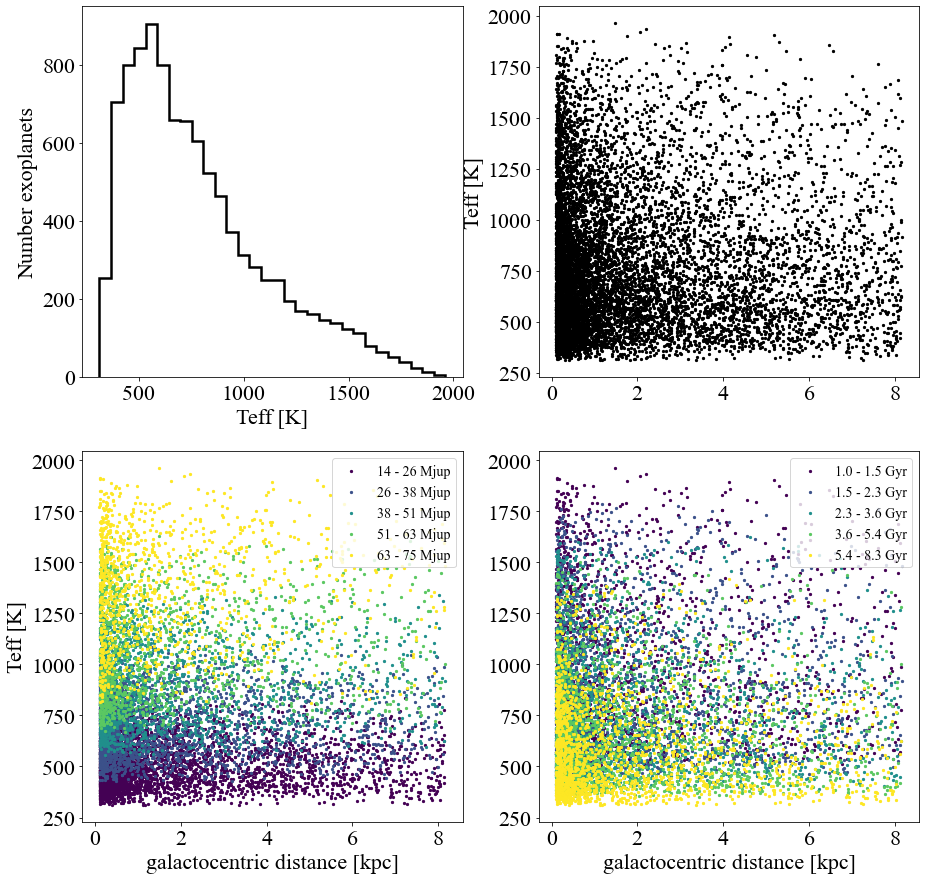

In [128]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
_, _, _ = ax[0, 0].hist(Teff, bins=30, histtype="step", linewidth=2.5, color="k")
ax[0, 0].set_xlabel("Teff [K]")
ax[0, 0].set_ylabel("Number exoplanets")

ax[0, 1].scatter(r_obs, Teff, s=5, color="k")
ax[0, 1].set_ylabel("Teff [K]")

colors = bokeh.palettes.viridis(5)
mass_bins = np.linspace(14, 75, 6)*M_jup/M_sun
for i in range(len(mass_bins)-1):
    pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]))
    ax[1, 0].scatter(r_obs[pos], Teff[pos], s=5, color=colors[i], 
                     label=("%i - %i Mjup" %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup))))
ax[1, 0].set_ylabel("Teff [K]")
ax[1, 0].set_xlabel("galactocentric distance [kpc]")
ax[1, 0].legend(frameon=True, fontsize=14)

age_bins = np.linspace(9, 9.92, 6)
for i in range(len(age_bins)-1):
    pos = np.where((log_ages > age_bins[i]) & (log_ages < age_bins[i+1]))
    ax[1, 1].scatter(r_obs[pos], Teff[pos], s=5, color=colors[i], 
                     label=("%.1f - %.1f Gyr" %(10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))    
ax[1, 1].set_xlabel("galactocentric distance [kpc]")
ax[1, 1].legend(frameon=True, fontsize=14)

Add DM contribution

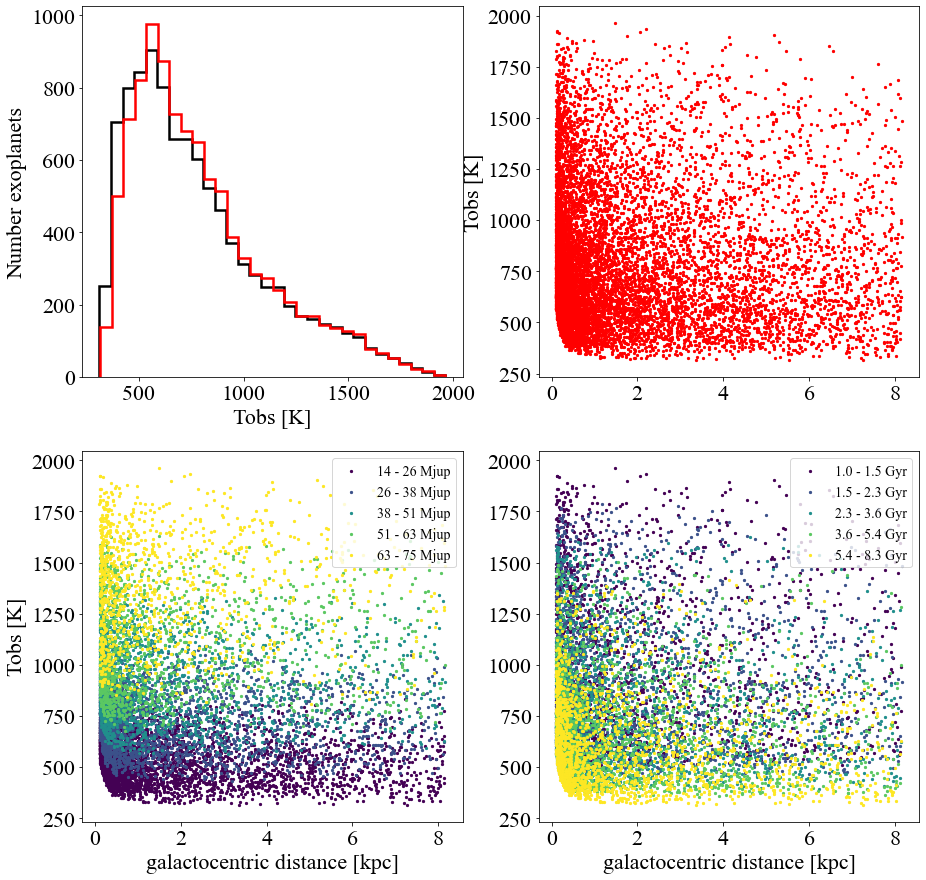

In [127]:
Tobs = temperature_withDM(r_obs, heat_int, f=1, R=R_jup.value, 
                          M=mass*M_sun.value, parameters=[1, 20, 0.42])
#Tobs = Tobs + 0.1*np.random.normal(loc=0, scale=(0.1*Tobs), size=N)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
_, _, _ = ax[0, 0].hist(Teff, bins=30, histtype="step", linewidth=2.5, color="k")
_, _, _ = ax[0, 0].hist(Tobs, bins=30, histtype="step", linewidth=2.5, color="r")
ax[0, 0].set_xlabel("Tobs [K]")
ax[0, 0].set_ylabel("Number exoplanets")

ax[0, 1].scatter(r_obs, Tobs, s=5, color="r")
ax[0, 1].set_ylabel("Tobs [K]")

colors = bokeh.palettes.viridis(5)
mass_bins = np.linspace(14, 75, 6)*M_jup/M_sun
for i in range(len(mass_bins)-1):
    pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]))
    ax[1, 0].scatter(r_obs[pos], Tobs[pos], s=5, color=colors[i], 
                     label=("%i - %i Mjup" %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup))))
ax[1, 0].set_ylabel("Tobs [K]")
ax[1, 0].set_xlabel("galactocentric distance [kpc]")
ax[1, 0].legend(frameon=True, fontsize=14)

age_bins = np.linspace(9, 9.92, 6)
for i in range(len(age_bins)-1):
    pos = np.where((log_ages > age_bins[i]) & (log_ages < age_bins[i+1]))
    ax[1, 1].scatter(r_obs[pos], Tobs[pos], s=5, color=colors[i], 
                     label=("%.1f - %.1f Gyr" %(10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))    
ax[1, 1].set_xlabel("galactocentric distance [kpc]")
ax[1, 1].legend(frameon=True, fontsize=14)

Text(0.5, 0, 'Teff [K]')

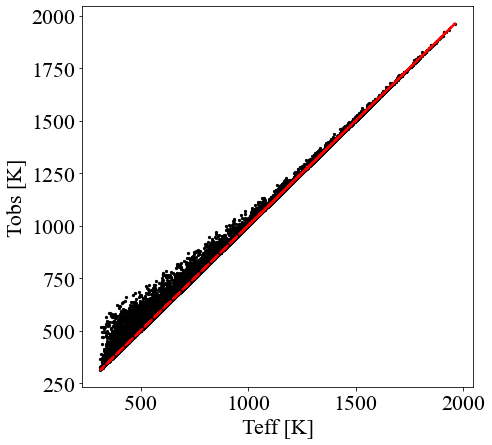

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(Teff, Tobs, color="k", s=5)
ax.plot(Tobs, Tobs, lw=2.5, ls="--", color="red")
ax.set_ylabel("Tobs [K]")
ax.set_xlabel("Teff [K]")

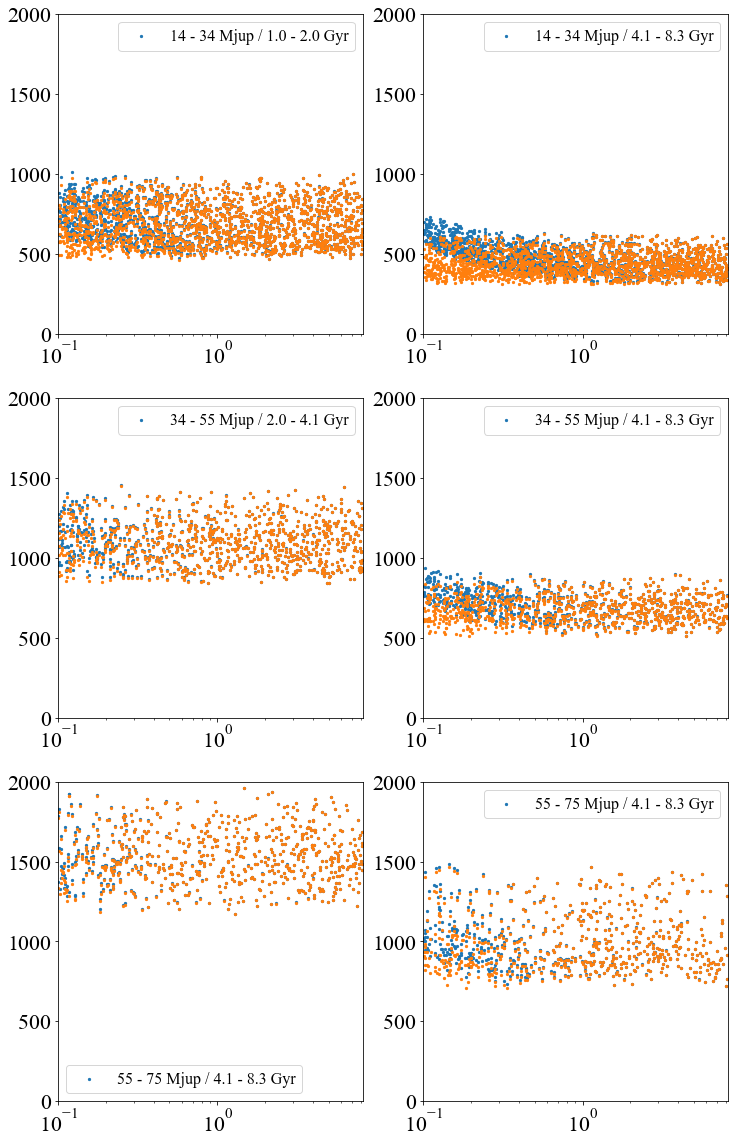

In [168]:
fig, ax = plt.subplots(3, 2, figsize=(12, 20))


mass_bins = np.linspace(14, 75, 4)*M_jup/M_sun
age_bins = np.linspace(9, 9.92, 4)

i = 0
pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[0]) & (log_ages < age_bins[1]))
ax[0, 0].scatter(r_obs[pos], Tobs[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))
ax[0, 0].scatter(r_obs[pos], Teff[pos], s=5)

pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[2]) & (log_ages < age_bins[3]))
ax[0, 1].scatter(r_obs[pos], Tobs[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[2]/10**9, 10**age_bins[3]/10**9)))
ax[0, 1].scatter(r_obs[pos], Teff[pos], s=5)


i = 1
pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[0]) & (log_ages < age_bins[1]))
ax[1, 0].scatter(r_obs[pos], Tobs[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))
ax[1, 0].scatter(r_obs[pos], Teff[pos], s=5)

pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[2]) & (log_ages < age_bins[3]))
ax[1, 1].scatter(r_obs[pos], Tobs[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[2]/10**9, 10**age_bins[3]/10**9)))
ax[1, 1].scatter(r_obs[pos], Teff[pos], s=5)

i = 2
pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[0]) & (log_ages < age_bins[1]))
ax[2, 0].scatter(r_obs[pos], Tobs[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))
ax[2, 0].scatter(r_obs[pos], Teff[pos], s=5)

pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[2]) & (log_ages < age_bins[3]))
ax[2, 1].scatter(r_obs[pos], Tobs[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[2]/10**9, 10**age_bins[3]/10**9)))
ax[2, 1].scatter(r_obs[pos], Teff[pos], s=5)

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2000])
        ax[i, j].set_xlim([0.1, 8.178])
        ax[i, j].set_xscale("log")
        ax[i, j].legend(frameon=True, fontsize=16)

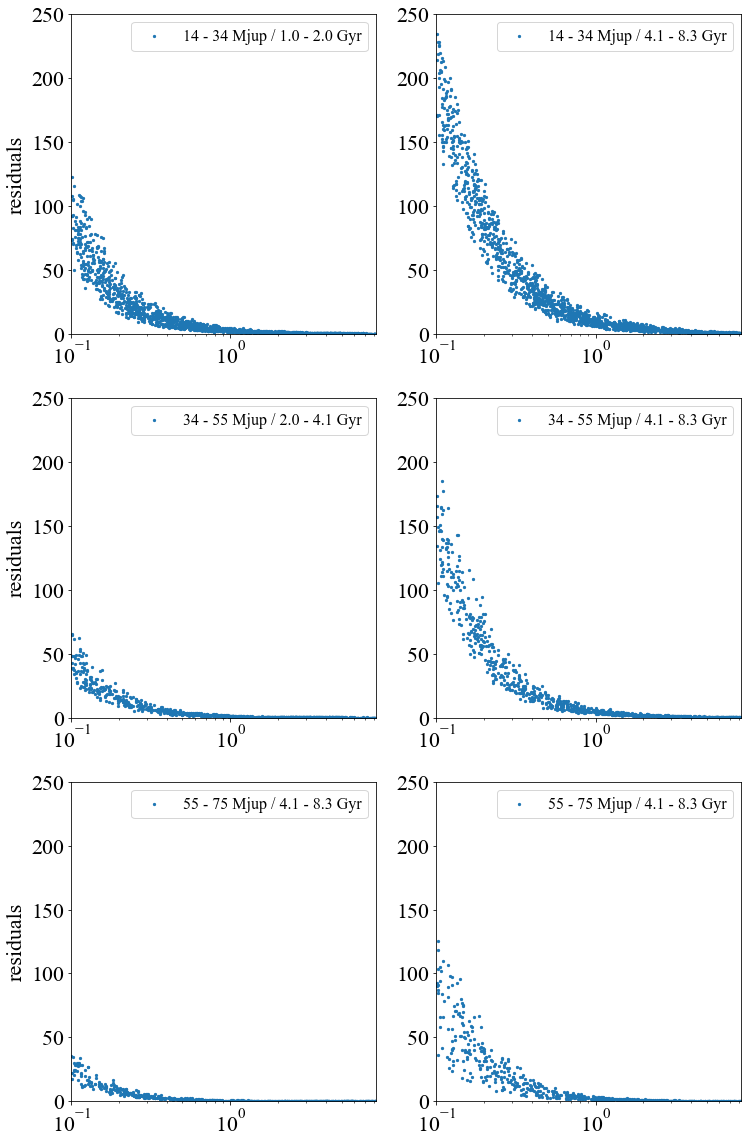

In [169]:
fig, ax = plt.subplots(3, 2, figsize=(12, 20))


mass_bins = np.linspace(14, 75, 4)*M_jup/M_sun
age_bins = np.linspace(9, 9.92, 4)

i = 0
pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[0]) & (log_ages < age_bins[1]))
ax[0, 0].scatter(r_obs[pos], Tobs[pos]-Teff[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))

pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[2]) & (log_ages < age_bins[3]))
ax[0, 1].scatter(r_obs[pos], Tobs[pos]-Teff[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[2]/10**9, 10**age_bins[3]/10**9)))


i = 1
pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[0]) & (log_ages < age_bins[1]))
ax[1, 0].scatter(r_obs[pos], Tobs[pos]-Teff[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))

pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[2]) & (log_ages < age_bins[3]))
ax[1, 1].scatter(r_obs[pos], Tobs[pos]-Teff[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[2]/10**9, 10**age_bins[3]/10**9)))

i = 2
pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[0]) & (log_ages < age_bins[1]))
ax[2, 0].scatter(r_obs[pos], Tobs[pos]-Teff[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))

pos = np.where((mass > mass_bins[i]) & (mass < mass_bins[i+1]) & 
               (log_ages > age_bins[2]) & (log_ages < age_bins[3]))
ax[2, 1].scatter(r_obs[pos], Tobs[pos]-Teff[pos], s=5, 
                label=("%i - %i Mjup / %.1f - %.1f Gyr" 
                       %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup), 
                         10**age_bins[2]/10**9, 10**age_bins[3]/10**9)))

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 250])
        ax[i, j].set_xlim([0.1, 8.178])
        ax[i, j].set_xscale("log")
        if j==0:
            ax[i, j].set_ylabel("Tobs - Teff")
        ax[i, j].legend(frameon=True, fontsize=16)

### Cut observations

- with observed temperature larger than 1000 K

In [123]:
pos = np.where(Tobs < 1000)
print (N, len(pos[0]))

Teff_cut  = np.copy(Teff[pos])
r_obs_cut = np.copy(r_obs[pos])
Tobs_cut  = np.copy(Tobs[pos])
mass_cut  = np.copy(mass[pos])
log_ages_cut = np.copy(log_ages[pos])

10000 7681


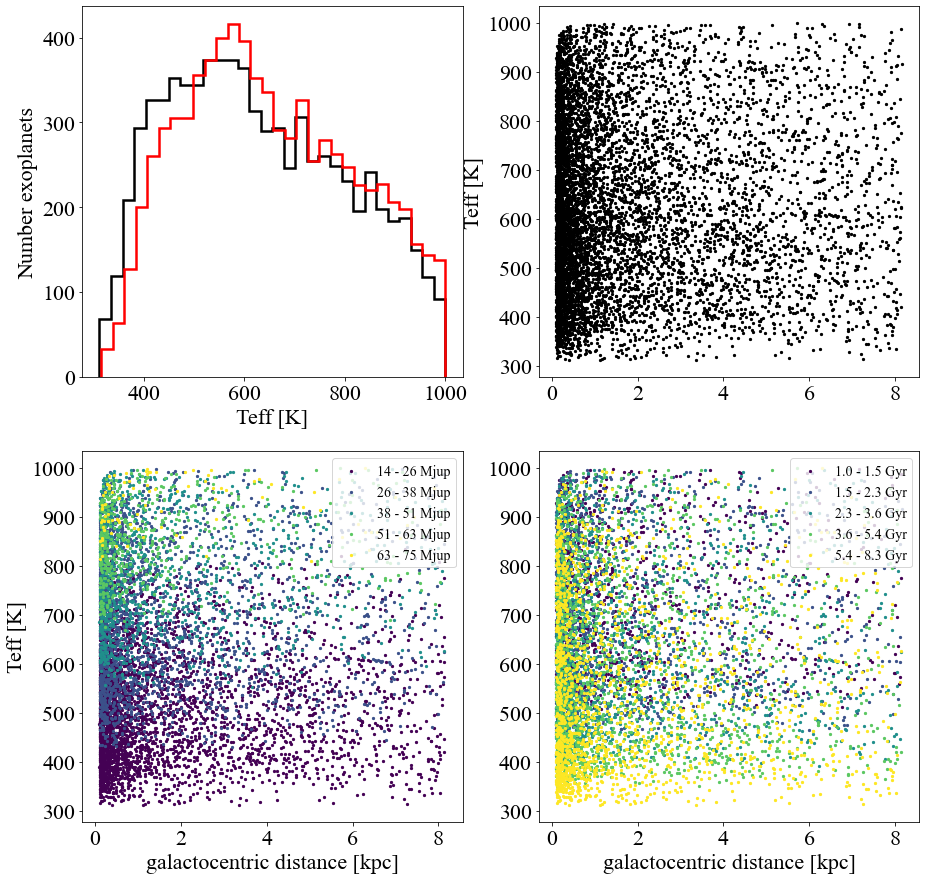

In [124]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
_, _, _ = ax[0, 0].hist(Teff_cut, bins=30, histtype="step", linewidth=2.5, color="k")
_, _, _ = ax[0, 0].hist(Tobs_cut, bins=30, histtype="step", linewidth=2.5, color="r")
ax[0, 0].set_xlabel("Teff [K]")
ax[0, 0].set_ylabel("Number exoplanets")

ax[0, 1].scatter(r_obs_cut, Teff_cut, s=5, color="k")
ax[0, 1].set_ylabel("Teff [K]")

colors = bokeh.palettes.viridis(5)
mass_bins = np.linspace(14, 75, 6)*M_jup/M_sun
for i in range(len(mass_bins)-1):
    pos = np.where((mass_cut > mass_bins[i]) & (mass_cut < mass_bins[i+1]))
    ax[1, 0].scatter(r_obs_cut[pos], Teff_cut[pos], s=5, color=colors[i], 
                     label=("%i - %i Mjup" %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup))))
ax[1, 0].set_ylabel("Teff [K]")
ax[1, 0].set_xlabel("galactocentric distance [kpc]")
ax[1, 0].legend(frameon=True, fontsize=14)

age_bins = np.linspace(9, 9.92, 6)
for i in range(len(age_bins)-1):
    pos = np.where((log_ages_cut > age_bins[i]) & (log_ages_cut < age_bins[i+1]))
    ax[1, 1].scatter(r_obs_cut[pos], Teff_cut[pos], s=5, color=colors[i], 
                     label=("%.1f - %.1f Gyr" %(10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))    
ax[1, 1].set_xlabel("galactocentric distance [kpc]")
ax[1, 1].legend(frameon=True, fontsize=14)

Text(0.5, 0, 'log(age) [yr]')

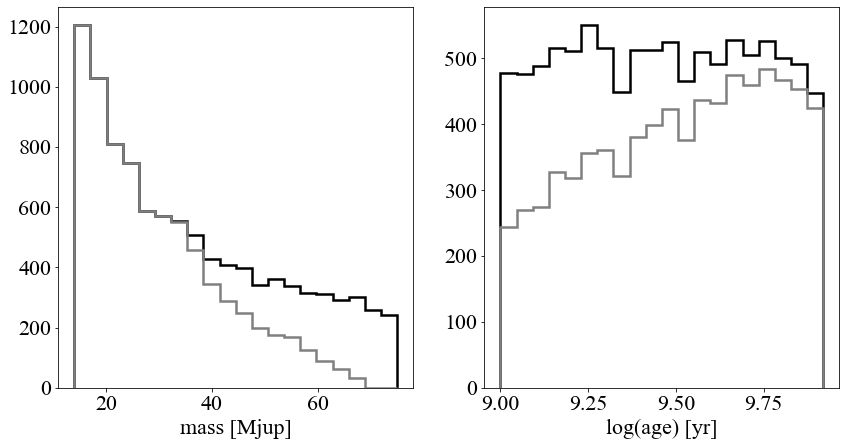

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
_, bins, _ = ax[0].hist((mass*M_sun/M_jup).value, bins=20, histtype="step", color="k", lw=2.5)
_, _, _  = ax[0].hist((mass_cut*M_sun/M_jup).value, bins=bins, histtype="step", color="grey", lw=2.5)
ax[0].set_xlabel("mass [Mjup]")

_, bins, _ = ax[1].hist(log_ages, bins=20, histtype="step", color="k", lw=2.5)
_, _, _  = ax[1].hist(log_ages_cut, bins=bins, histtype="step", color="grey", lw=2.5)
ax[1].set_xlabel("log(age) [yr]")

10000 7681


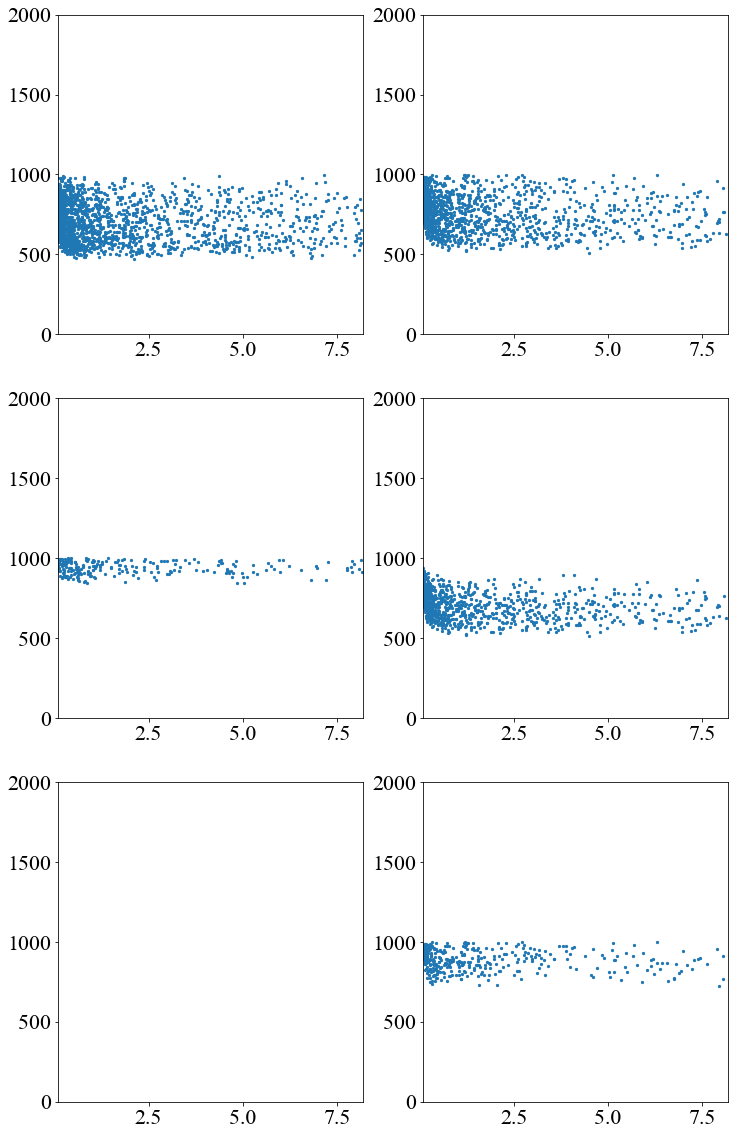

In [156]:
fig, ax = plt.subplots(3, 2, figsize=(12, 20))


mass_bins = np.linspace(14, 75, 4)*M_jup/M_sun
age_bins = np.linspace(9, 9.92, 4)

i = 0
pos = np.where((mass_cut > mass_bins[i]) & (mass_cut < mass_bins[i+1]) & 
               (log_ages_cut > age_bins[0]) & (log_ages_cut < age_bins[1]))
ax[0, 0].scatter(r_obs_cut[pos], Tobs_cut[pos], s=5)

pos = np.where((mass_cut > mass_bins[i]) & (mass_cut > mass_bins[i+1]) & 
               (log_ages_cut > age_bins[2]) & (log_ages_cut < age_bins[3]))
ax[0, 1].scatter(r_obs_cut[pos], Tobs_cut[pos], s=5)


i = 1
pos = np.where((mass_cut > mass_bins[i]) & (mass_cut < mass_bins[i+1]) & 
               (log_ages_cut > age_bins[0]) & (log_ages_cut < age_bins[1]))
ax[1, 0].scatter(r_obs_cut[pos], Tobs_cut[pos], s=5)

pos = np.where((mass_cut > mass_bins[i]) & (mass_cut < mass_bins[i+1]) & 
               (log_ages_cut > age_bins[2]) & (log_ages_cut < age_bins[3]))
ax[1, 1].scatter(r_obs_cut[pos], Tobs_cut[pos], s=5)


i = 2
pos = np.where((mass_cut > mass_bins[i]) & (mass_cut < mass_bins[i+1]) & 
               (log_ages_cut > age_bins[0]) & (log_ages_cut < age_bins[1]))
ax[2, 0].scatter(r_obs_cut[pos], Tobs_cut[pos], s=5)

pos = np.where((mass_cut > mass_bins[i]) & (mass_cut < mass_bins[i+1]) & 
               (log_ages_cut > age_bins[2]) & (log_ages_cut < age_bins[3]))
ax[2, 1].scatter(r_obs_cut[pos], Tobs_cut[pos], s=5)

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2000])
        ax[i, j].set_xlim([0.1, 8.178])

- with observed temperature larger than 1000 K and galactocentric distances larger than 1 kpc

Text(0.5, 0, 'log(age) [yr]')

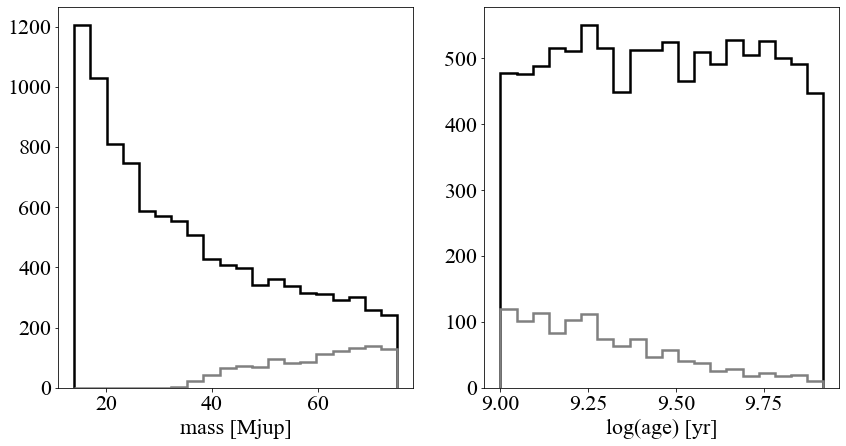

In [125]:
pos = np.where((Tobs > 1000) & (r_obs > 1))

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
_, bins, _ = ax[0].hist((mass*M_sun/M_jup).value, bins=20, histtype="step", color="k", lw=2.5)
_, _, _  = ax[0].hist((mass[pos]*M_sun/M_jup).value, bins=bins, histtype="step", color="grey", lw=2.5)
ax[0].set_xlabel("mass [Mjup]")

_, bins, _ = ax[1].hist(log_ages, bins=20, histtype="step", color="k", lw=2.5)
_, _, _  = ax[1].hist(log_ages[pos], bins=bins, histtype="step", color="grey", lw=2.5)
ax[1].set_xlabel("log(age) [yr]")

In [126]:
pos = np.where((Tobs > 1000) & (r_obs > 1))

Teff_cut  = np.delete(Teff, pos)
r_obs_cut = np.delete(r_obs, pos)
Tobs_cut  = np.delete(Tobs, pos)
mass_cut  = np.delete(mass, pos)
log_ages_cut = np.delete(log_ages, pos)

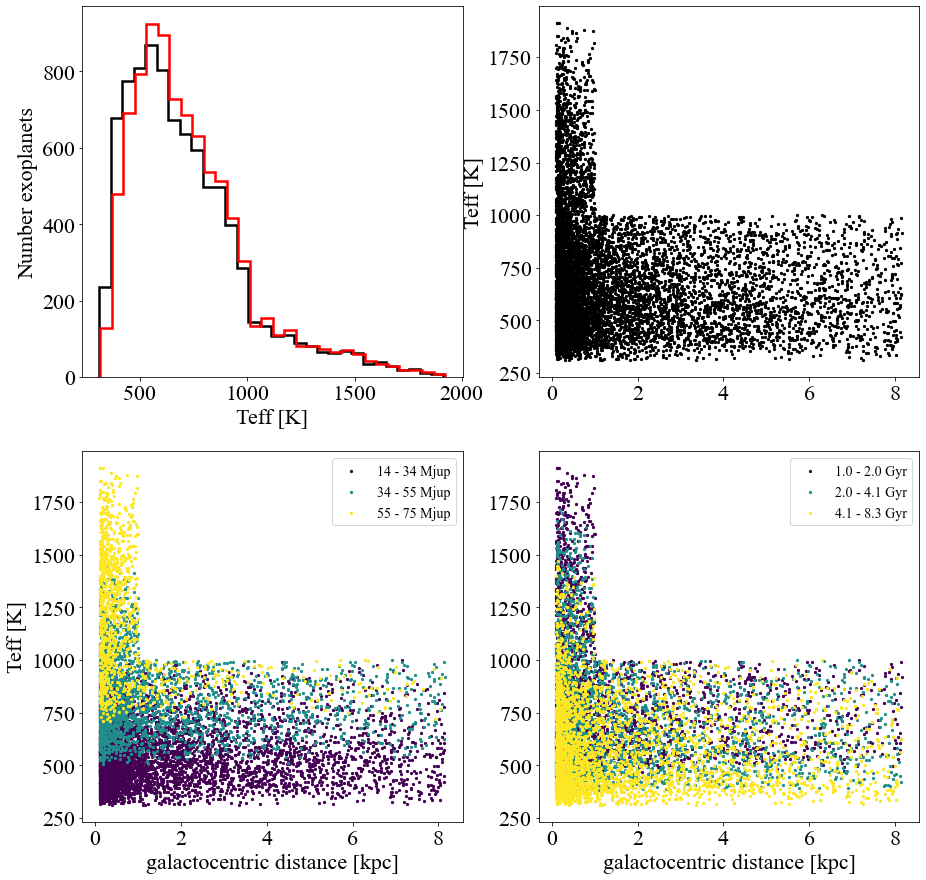

In [121]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
_, _, _ = ax[0, 0].hist(Teff_cut, bins=30, histtype="step", linewidth=2.5, color="k")
_, _, _ = ax[0, 0].hist(Tobs_cut, bins=30, histtype="step", linewidth=2.5, color="r")
ax[0, 0].set_xlabel("Teff [K]")
ax[0, 0].set_ylabel("Number exoplanets")

ax[0, 1].scatter(r_obs_cut, Teff_cut, s=5, color="k")
ax[0, 1].set_ylabel("Teff [K]")

colors = bokeh.palettes.viridis(3)
mass_bins = np.linspace(14, 75, 4)*M_jup/M_sun
for i in range(len(mass_bins)-1):
    pos = np.where((mass_cut > mass_bins[i]) & (mass_cut < mass_bins[i+1]))
    ax[1, 0].scatter(r_obs_cut[pos], Teff_cut[pos], s=5, color=colors[i], 
                     label=("%i - %i Mjup" %(np.round(mass_bins[i]*M_sun/M_jup), np.round(mass_bins[i+1]*M_sun/M_jup))))
ax[1, 0].set_ylabel("Teff [K]")
ax[1, 0].set_xlabel("galactocentric distance [kpc]")
ax[1, 0].legend(frameon=True, fontsize=14)

age_bins = np.linspace(9, 9.92, 4)
for i in range(len(age_bins)-1):
    pos = np.where((log_ages_cut > age_bins[i]) & (log_ages_cut < age_bins[i+1]))
    ax[1, 1].scatter(r_obs_cut[pos], Teff_cut[pos], s=5, color=colors[i], 
                     label=("%.1f - %.1f Gyr" %(10**age_bins[i]/10**9, 10**age_bins[i+1]/10**9)))    
ax[1, 1].set_xlabel("galactocentric distance [kpc]")
ax[1, 1].legend(frameon=True, fontsize=14)

Text(0.5, 0, 'Teff [K]')

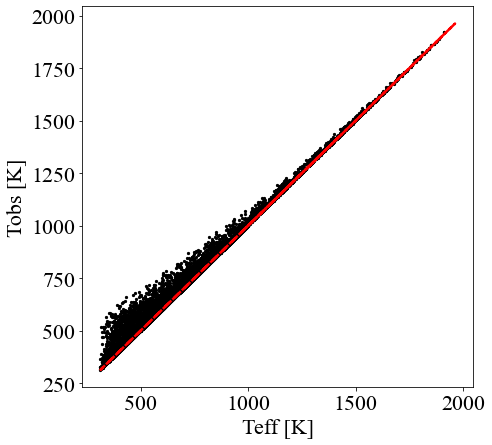

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(Teff_cut, Tobs_cut, color="k", s=5)
ax.plot(Tobs, Tobs, lw=2.5, ls="--", color="red")
ax.set_ylabel("Tobs [K]")
ax.set_xlabel("Teff [K]")

## Results fitting

In [202]:
_file   = open("../results/likelihood_old", "rb") 
like    = pickle.load(_file)
_file   = open("../results/posterior_old", "rb") 
samples = pickle.load(_file)

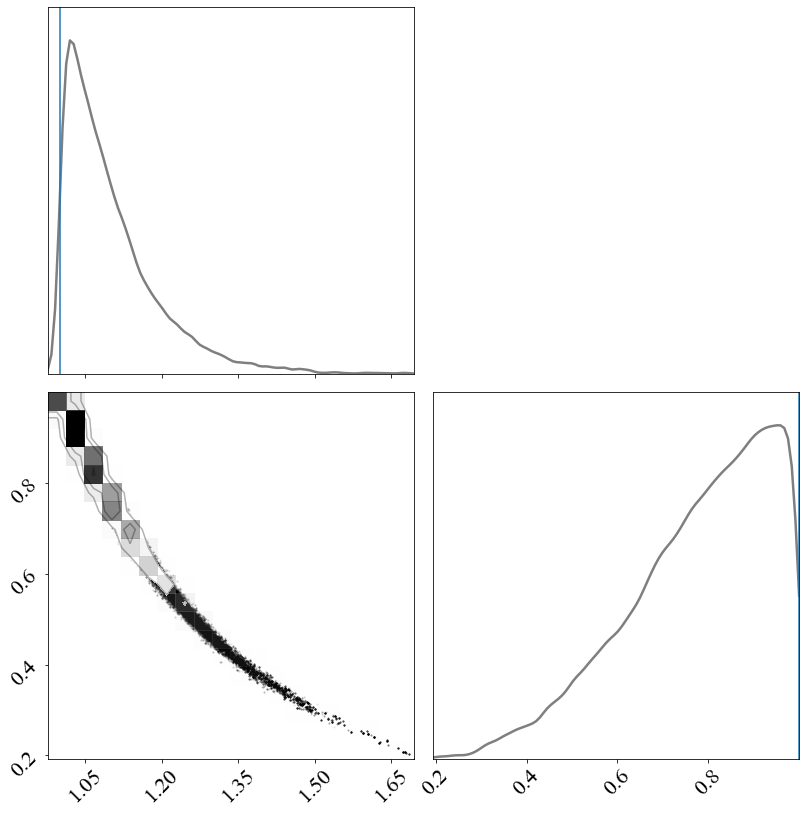

In [205]:
fig, axes = corner(samples)#, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, plot_density=False, 
                   #fill_contours=False)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 3], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5, alpha=0.5)

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0])
axes[1, 1].axvline(ML[1])
#axes[2, 2].axvline(ML[2])